## About the competition

                    







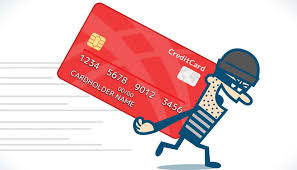

IEEE-CIS works across a variety of AI and machine learning areas, including deep neural networks, fuzzy systems, evolutionary computation, and swarm intelligence. Today they’re partnering with the world’s leading payment service company, Vesta Corporation, seeking the best solutions for fraud prevention industry, and now you are invited to join the challenge.

**Key Take Aways**

1) Effecting Data Minification

2) Creative Feature Enginnering

3) Exploratory Data Analysis

4) Advanced Machine Learning Techniques


This is the first time dealing with this kind of large data.I have referred a lot of resources for creating this kernel. This kernel is also influenced by some kernels and discussion from this competition. So I can assure you that this kernel will help you how to deal with large dataset if you are new in dealing with large dataset.

**Loading Necessary Libraries**

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import missingno as msno # visualize the distribution of NaN values
import seaborn as sns #Visualization of data
import matplotlib.pyplot as plt #Visualization of data
%matplotlib inline
import gc #Garbage collection
import datetime

## Reading the Files and Data Merging

In [2]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.



#Reading the input Files from their respective Directory
train_identity=pd.read_csv("/kaggle/input/ieee-fraud-detection/train_identity.csv")
train_transaction=pd.read_csv("/kaggle/input/ieee-fraud-detection/train_transaction.csv")
test_transaction=pd.read_csv("/kaggle/input/ieee-fraud-detection/test_transaction.csv")
test_identity=pd.read_csv("/kaggle/input/ieee-fraud-detection/test_identity.csv")

/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv


**Data Merging**

In [3]:
train_df = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
test_df= pd.merge(test_transaction, test_identity, on='TransactionID', how='left')

In [4]:
del train_identity
del train_transaction
del test_transaction
del test_identity
gc.collect()

0

## Reducing the memory of the data

The size of the dataset is pretty big, so we are trying to make the dataset smaller without losing information. 

**Reason behind memory Reduction:**

Int16: 2 bytes

Int32 and int: 4 bytes

Int64 : 8 bytes

This is an example how different integer types are occupying the memory. In many cases it is not necessary to represent our integer as int64 and int32 it is just waste of memory. So I am trying to understand the necessaity of every numerical representation and try to convert the unnecessary higher numerical representation to lower one. In that, we can reduce the memory without losing the memory.
 

In [5]:
def reduce_mem_usage(df):
    start_mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage of properties dataframe is :",start_mem_usg," MB")
    NAlist = [] # Keeps track of columns that have missing values filled in. 
    for col in df.columns:
        if df[col].dtype != object:  # Exclude strings
            
            # make variables for Int, max and min
            IsInt = False
            mx = df[col].max()
            mn = df[col].min()
            
            #Integer does not support NA, therefore, NA needs to be filled
            if not np.isfinite(df[col]).all(): 
               NAlist.append(col)
               df[col].fillna(-999,inplace=True)  
                   
            # test if column can be converted to an integer
            asint = df[col].fillna(0).astype(np.int64)
            result = (df[col] - asint)
            result = result.sum()
            if result > -0.01 and result < 0.01:
                IsInt = True

            
            # Make Integer/unsigned Integer datatypes
            if IsInt:
                if mn >= 0:
                    if mx < 255:
                        df[col] = df[col].astype(np.uint8)
                    elif mx < 65535:
                        df[col] = df[col].astype(np.uint16)
                    elif mx < 4294967295:
                        df[col] = df[col].astype(np.uint32)
                    else:
                        df[col] = df[col].astype(np.uint64)
                else:
                    if mn > np.iinfo(np.int8).min and mx < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif mn > np.iinfo(np.int16).min and mx < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif mn > np.iinfo(np.int32).min and mx < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif mn > np.iinfo(np.int64).min and mx < np.iinfo(np.int64).max:
                        df[col] =df[col].astype(np.int64)    
            
            # Make float datatypes 32 bit
            else:
                df[col] = df[col].astype(np.float32)
            
    # Print final result
    print("___MEMORY USAGE AFTER COMPLETION:___")
    mem_usg = df.memory_usage().sum() / 1024**2 
    print("Memory usage is: ",mem_usg," MB")
    print("This is ",100*mem_usg/start_mem_usg,"% of the initial size")
    return df,NAlist

**Reducing Memory For training data**

In [6]:
train,train_Na=reduce_mem_usage(train_df)

Memory usage of properties dataframe is : 1959.8762512207031  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  550.7928085327148  MB
This is  28.103448275862068 % of the initial size


**Reducing Memory for test data**

In [7]:
test,test_Na=reduce_mem_usage(test_df)

Memory usage of properties dataframe is : 1677.7335662841797  MB
___MEMORY USAGE AFTER COMPLETION:___
Memory usage is:  462.92302894592285  MB
This is  27.592165898617512 % of the initial size


**How this helps?**

Here I am reducing the memory of the dataset by 72% without losing the data. This will have a great impact while training our model. It will reduce the training time by a very large margin. 

In [8]:
del train_df,test_df
gc.collect()

0

** Quick Recap on Data **

**Numeric AND Categorical Columns**

In [9]:
cols=train.columns
num_cols=train._get_numeric_data().columns
cat_cols=list(set(cols)-set(num_cols))
print("Numeric Columns:",num_cols)
print("Categoric Columns:",cat_cols)

Numeric Columns: Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22', 'id_24', 'id_25',
       'id_26', 'id_32'],
      dtype='object', length=403)
Categoric Columns: ['ProductCD', 'P_emaildomain', 'M8', 'id_28', 'id_16', 'M1', 'M3', 'id_27', 'id_23', 'M2', 'card4', 'id_31', 'id_34', 'M9', 'id_38', 'M4', 'M7', 'DeviceType', 'DeviceInfo', 'id_36', 'id_29', 'id_12', 'M5', 'id_35', 'R_emaildomain', 'id_37', 'id_30', 'id_33', 'card6', 'id_15', 'M6']


## Exploratory Data  Analysis

**Time period of the data**

The TransactionDT feature is a timedelta from a given reference datetime (not an actual timestamp). Let's assume the start time is from December 1,2017 and see how the data is distributed between Train and Test data

In [10]:
startdate = datetime.datetime.strptime('2017-12-01', '%Y-%m-%d')
train['TransactionDT'] = train['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))
test['TransactionDT'] = test['TransactionDT'].apply(lambda x: (startdate + datetime.timedelta(seconds = x)))

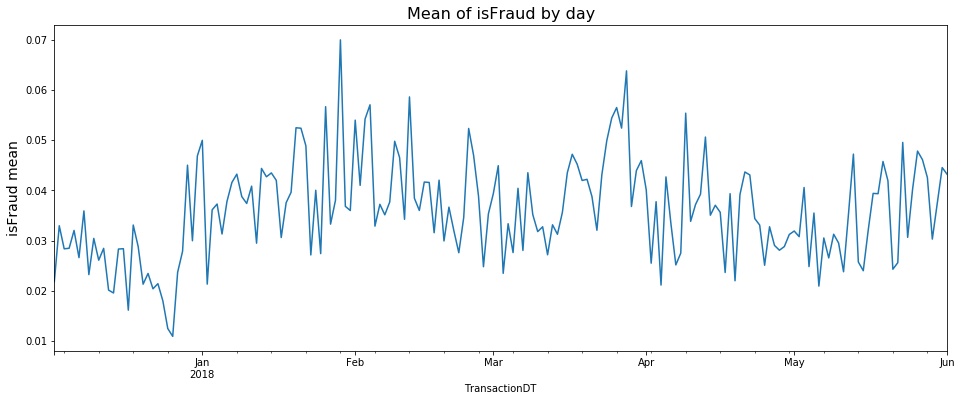

In [11]:
fig, axes = plt.subplots(1, 1, figsize=(16, 6))
train.set_index('TransactionDT').resample('D').mean()['isFraud'].plot(ax=axes).set_ylabel('isFraud mean', fontsize=14);
axes.set_title('Mean of isFraud by day', fontsize=16);


Distribution of the data from Dec 2017 to Jun 2019 as we assumed We can see the pattern of transaction on each day


**Categorical Data Exploration**

**Missing Nature of Categorical Data**

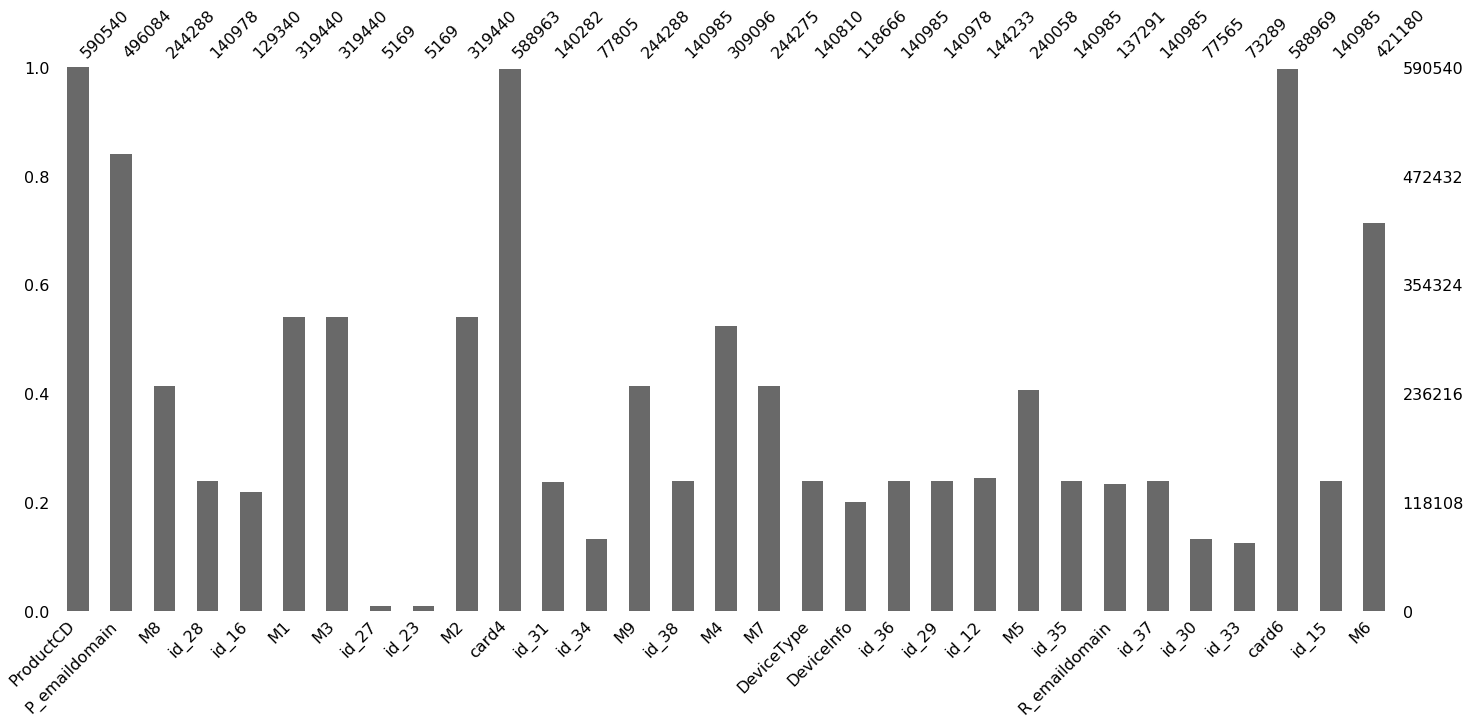

In [12]:
msno.bar(train[cat_cols])

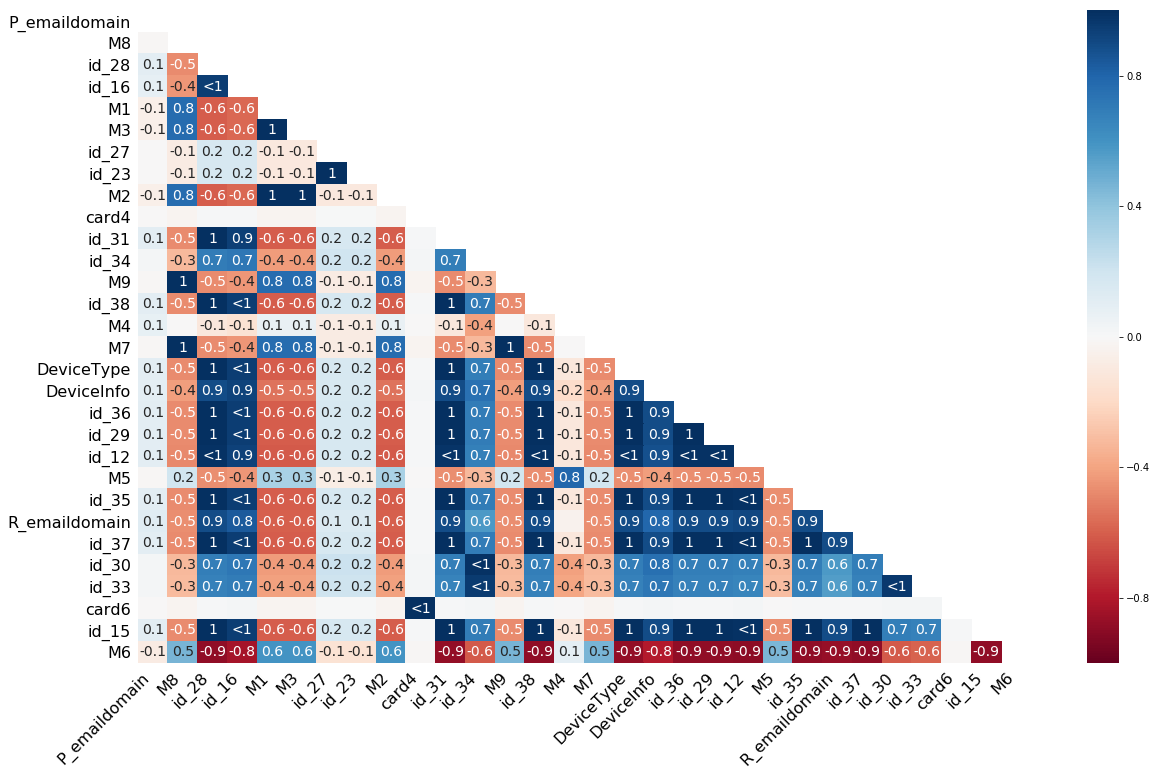

In [13]:
# Visualize the correlation between the number of 
# missing values in different columns as a heatmap 
msno.heatmap(train[cat_cols])

**How it works?**
  
  This heatmap tells the correlation between the missing nature of the data.**Example:** id_15 and id_28 has a correlation of 1 which means if one variable appears then the other variable is very likely to be **present**. 

**Breaking domain the purchaser domain**

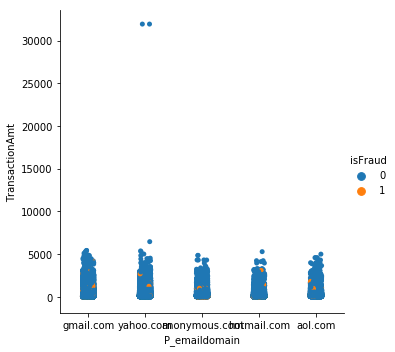

In [14]:
import seaborn as sns
domain=train.P_emaildomain.value_counts()[:5].index    #Selecting Top 5 most used domains
temp=train.loc[train["P_emaildomain"].isin(domain)]
sns.catplot(x="P_emaildomain", y="TransactionAmt",hue="isFraud",data=temp)

Observation:
   The distribution of Fraud's in each user domain is very less

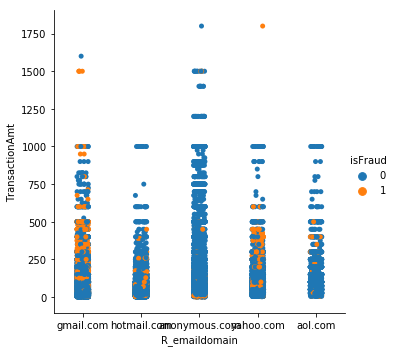

In [15]:
import seaborn as sns
domain=train.R_emaildomain.value_counts()[:5].index    #Selecting Top 5 most used domains
temp=train.loc[train["R_emaildomain"].isin(domain)]
sns.catplot(x="R_emaildomain", y="TransactionAmt", hue="isFraud", data=temp)


**Observation**
The distribution of Fraud's in Retailer's domain is pretty high.

In [16]:
del temp
gc.collect()

0

**Device Type**

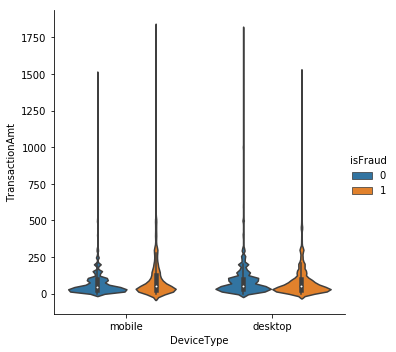

In [17]:
sns.catplot(x="DeviceType", y="TransactionAmt", hue="isFraud",kind="violin", data=train)

**Card 6**

It is about whether the is Debit or Credit Card

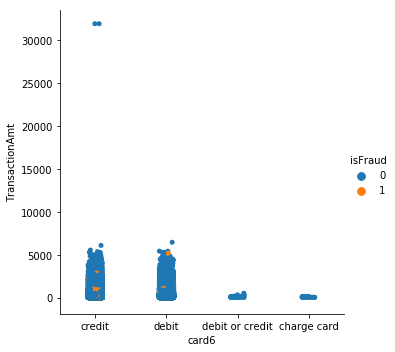

In [18]:
sns.catplot(x="card6", y="TransactionAmt", hue="isFraud", data=train)

**Observation:**

Fraud's are using credit and debit card they are **not** using **charge card** and **debit or credit**

**Device Info**

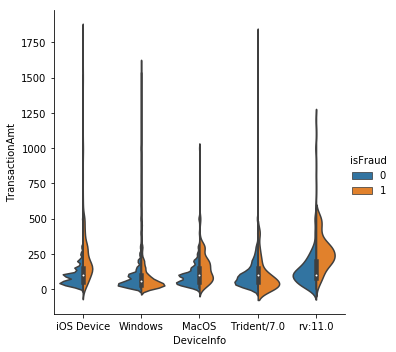

In [19]:
domain=train.DeviceInfo.value_counts()[:5].index    #Selecting Top 5 most used domains
temp=train.loc[train["DeviceInfo"].isin(domain)]
sns.catplot(x="DeviceInfo", y="TransactionAmt", hue="isFraud",kind="violin", split=True, data=temp)

**Observation:**



Frauds are distributed equally among all the devices

**ProductCD**

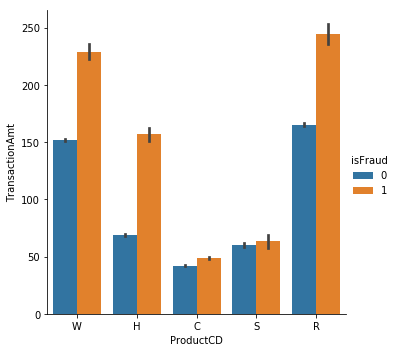

In [20]:
sns.catplot(x="ProductCD", y="TransactionAmt", hue="isFraud", kind="bar", data=train)

**Card 4**

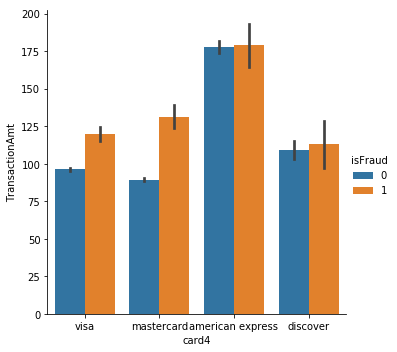

In [21]:

sns.catplot(x="card4", y="TransactionAmt", hue="isFraud",kind="bar", data=temp)

**Id's and their Nature**

There are 14 categorical columns representing ID's lets find out what they are about..

In [22]:
Id=['id_35','id_38','id_16','id_33','id_28','id_37','id_30','id_12','id_29','id_36','id_31','id_23','id_27','id_34','id_15']

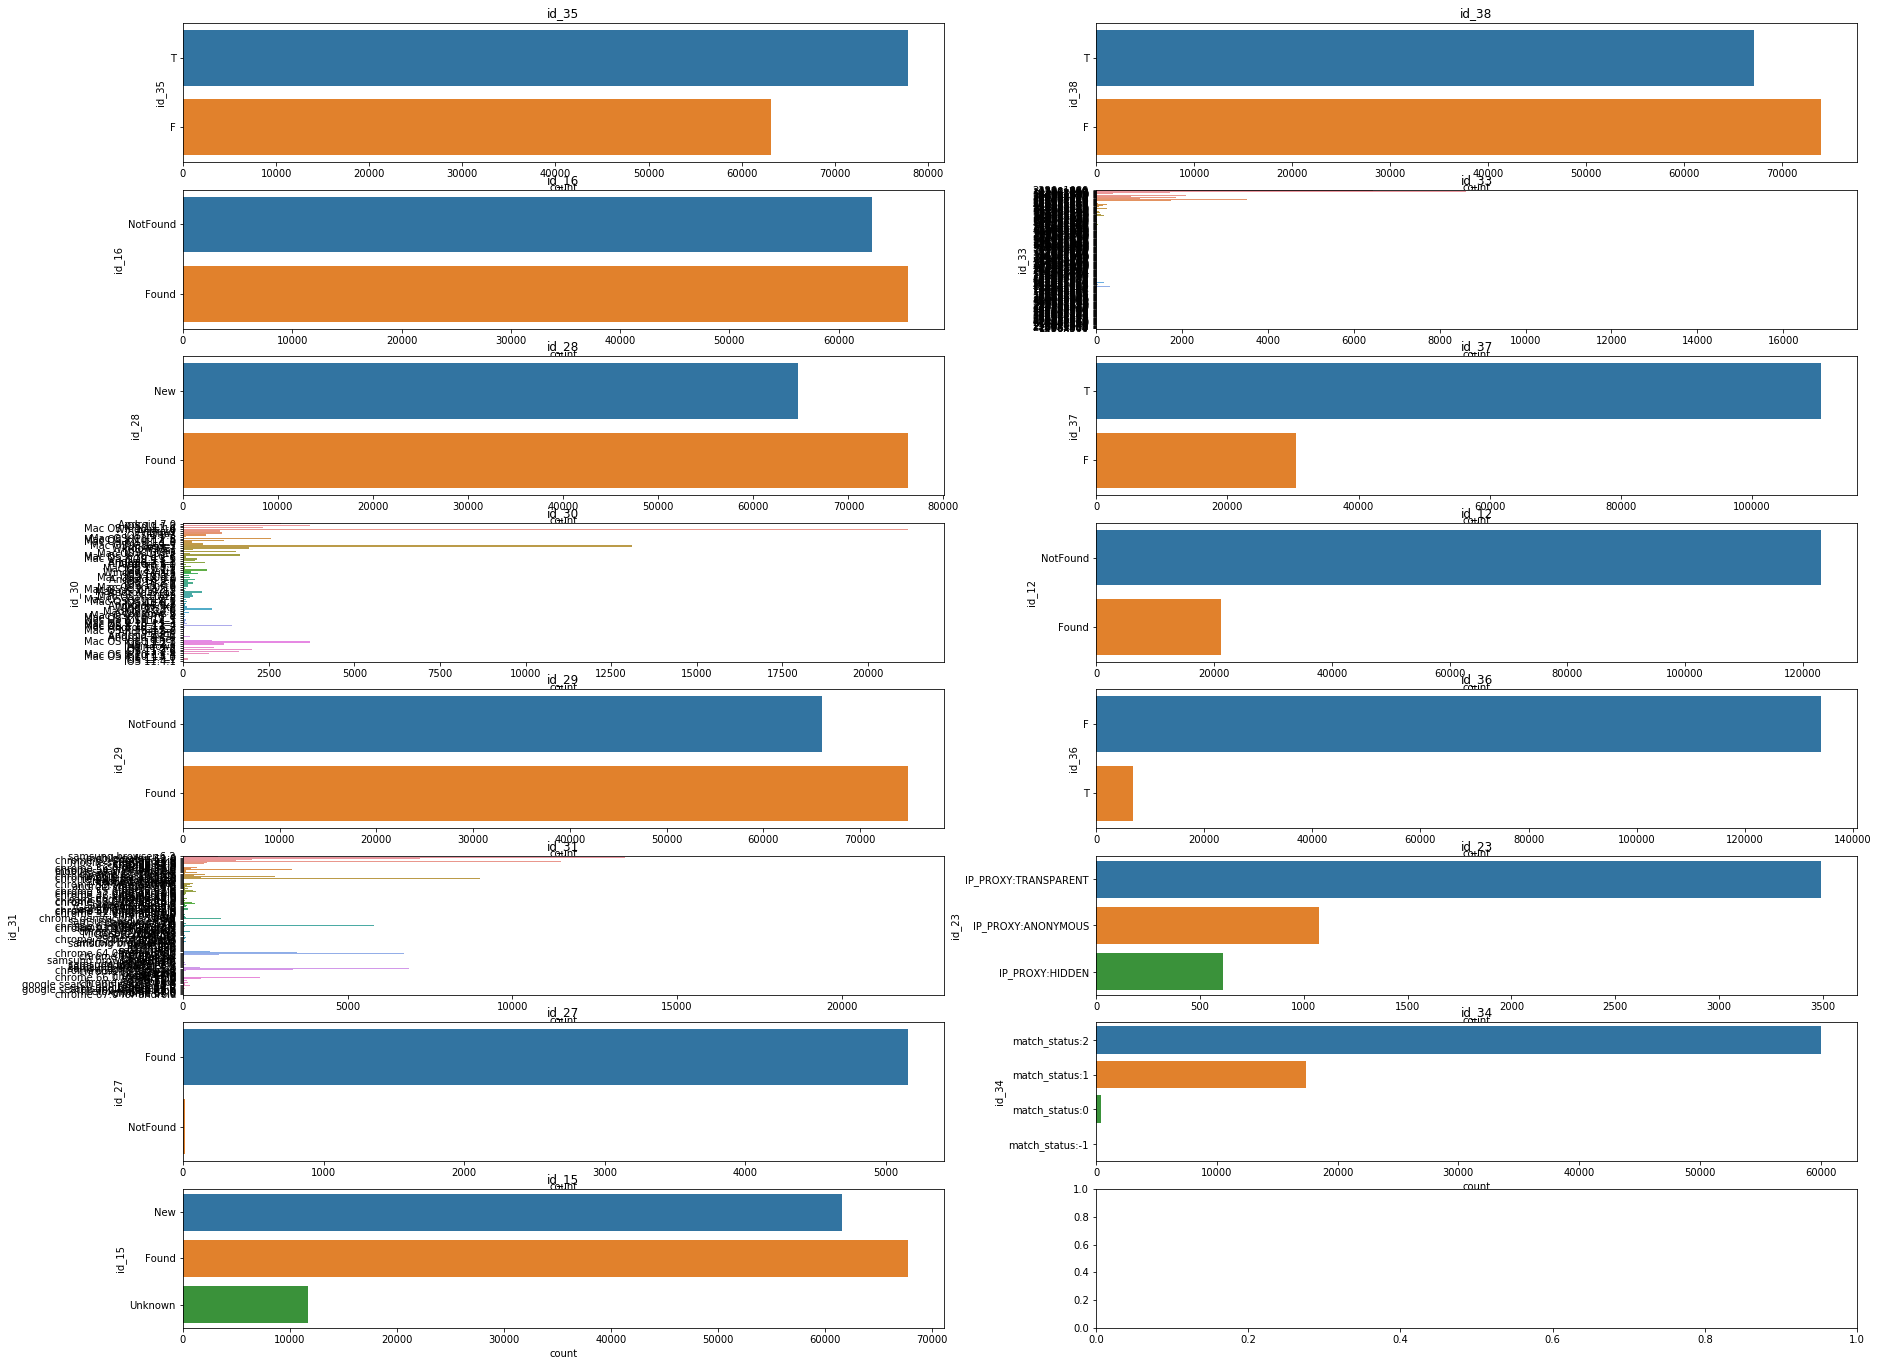

In [23]:
f, axes = plt.subplots(8, 2,figsize=(30,24))
for i in range(0,len(Id)):
    sns.countplot(y=train[Id[i]],data=train,ax=axes.flatten()[i])
    axes.flatten()[i].set_title(Id[i])

**Observations:**

1) From the figure we are able to understand what the data is about. It gives some idea about their distrubution


2) Id_31, Id_33, Id_30 the data is very micro level. The data is very much distributed. Let's further understand what they are about

**Id_31**

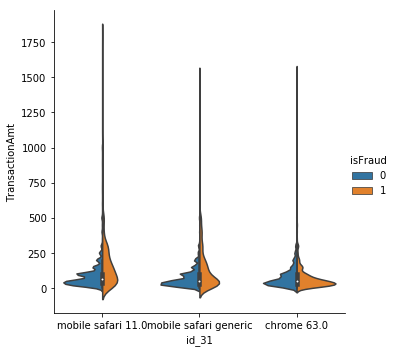

In [24]:
domain=train.id_31.value_counts()[:3].index    #Selecting Top 5 most used domains
temp=train.loc[train["id_31"].isin(domain)]
sns.catplot(x="id_31", y="TransactionAmt", hue="isFraud",kind="violin", split=True, data=temp)

**Observation**

Id_31 is about version of browser and type of device combined

**Id_33**

/opt/conda/lib/python3.6/site-packages/seaborn/categorical.py:2775: UserWarning: The `split` parameter has been renamed to `dodge`.
  warnings.warn(msg, UserWarning)


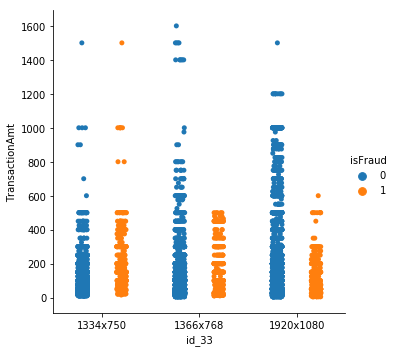

In [25]:
domain=train.id_33.value_counts()[:3].index    #Selecting Top 5 most used domains
temp=train.loc[train["id_33"].isin(domain)]
sns.catplot(x="id_33", y="TransactionAmt", hue="isFraud", split=True, data=temp)

**Observation**

Id_33 is about the resolution of the device you are using


**Id30**

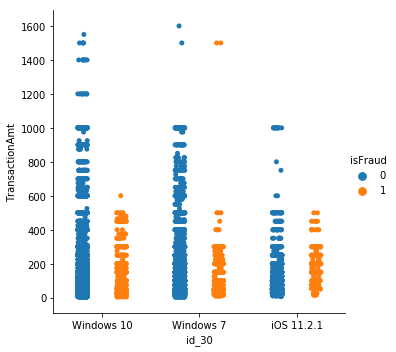

In [26]:
domain=train.id_30.value_counts()[:3].index    #Selecting Top 5 most used domains
temp=train.loc[train["id_30"].isin(domain)]
sns.catplot(x="id_30", y="TransactionAmt", hue="isFraud", split=True, data=temp)

**Observation**

Id_30 is about the windows/Andriod version the user has used

Exploring the **M** series variable

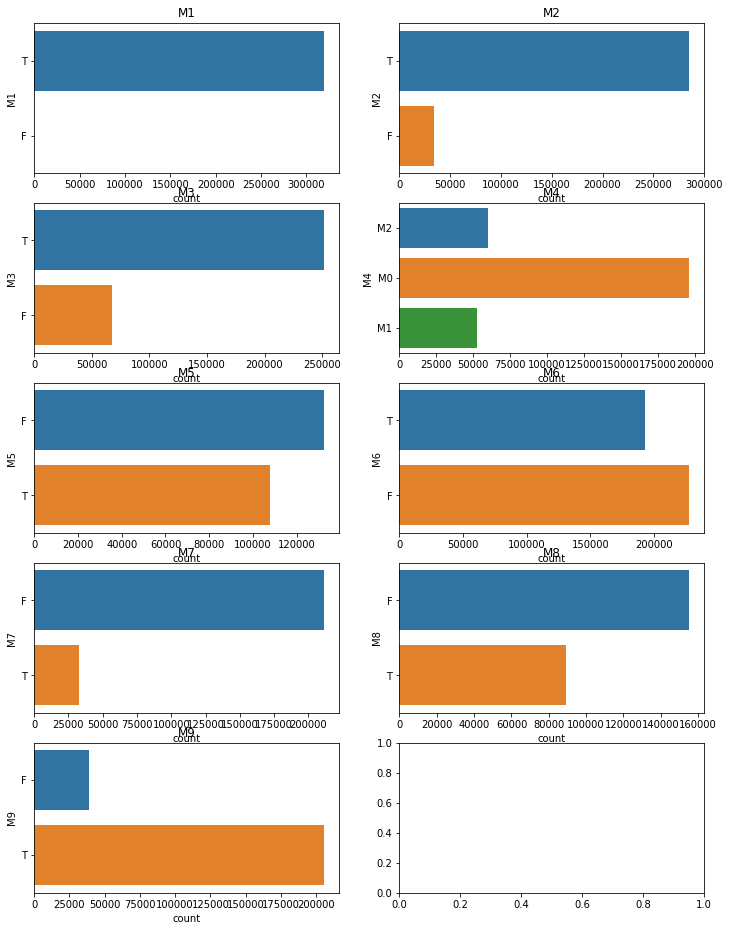

In [27]:
Id=['M1','M2','M3','M4','M5','M6','M7','M8','M9']
f, axes = plt.subplots(5, 2,figsize=(12,16))
for i in range(0,len(Id)):
    sns.countplot(y=train[Id[i]],data=train,ax=axes.flatten()[i])
    axes.flatten()[i].set_title(Id[i])

**Numerical Data Exploration**

**V** what is the relationship between them?


In [28]:

filter_col = [col for col in train if col.startswith('V')]

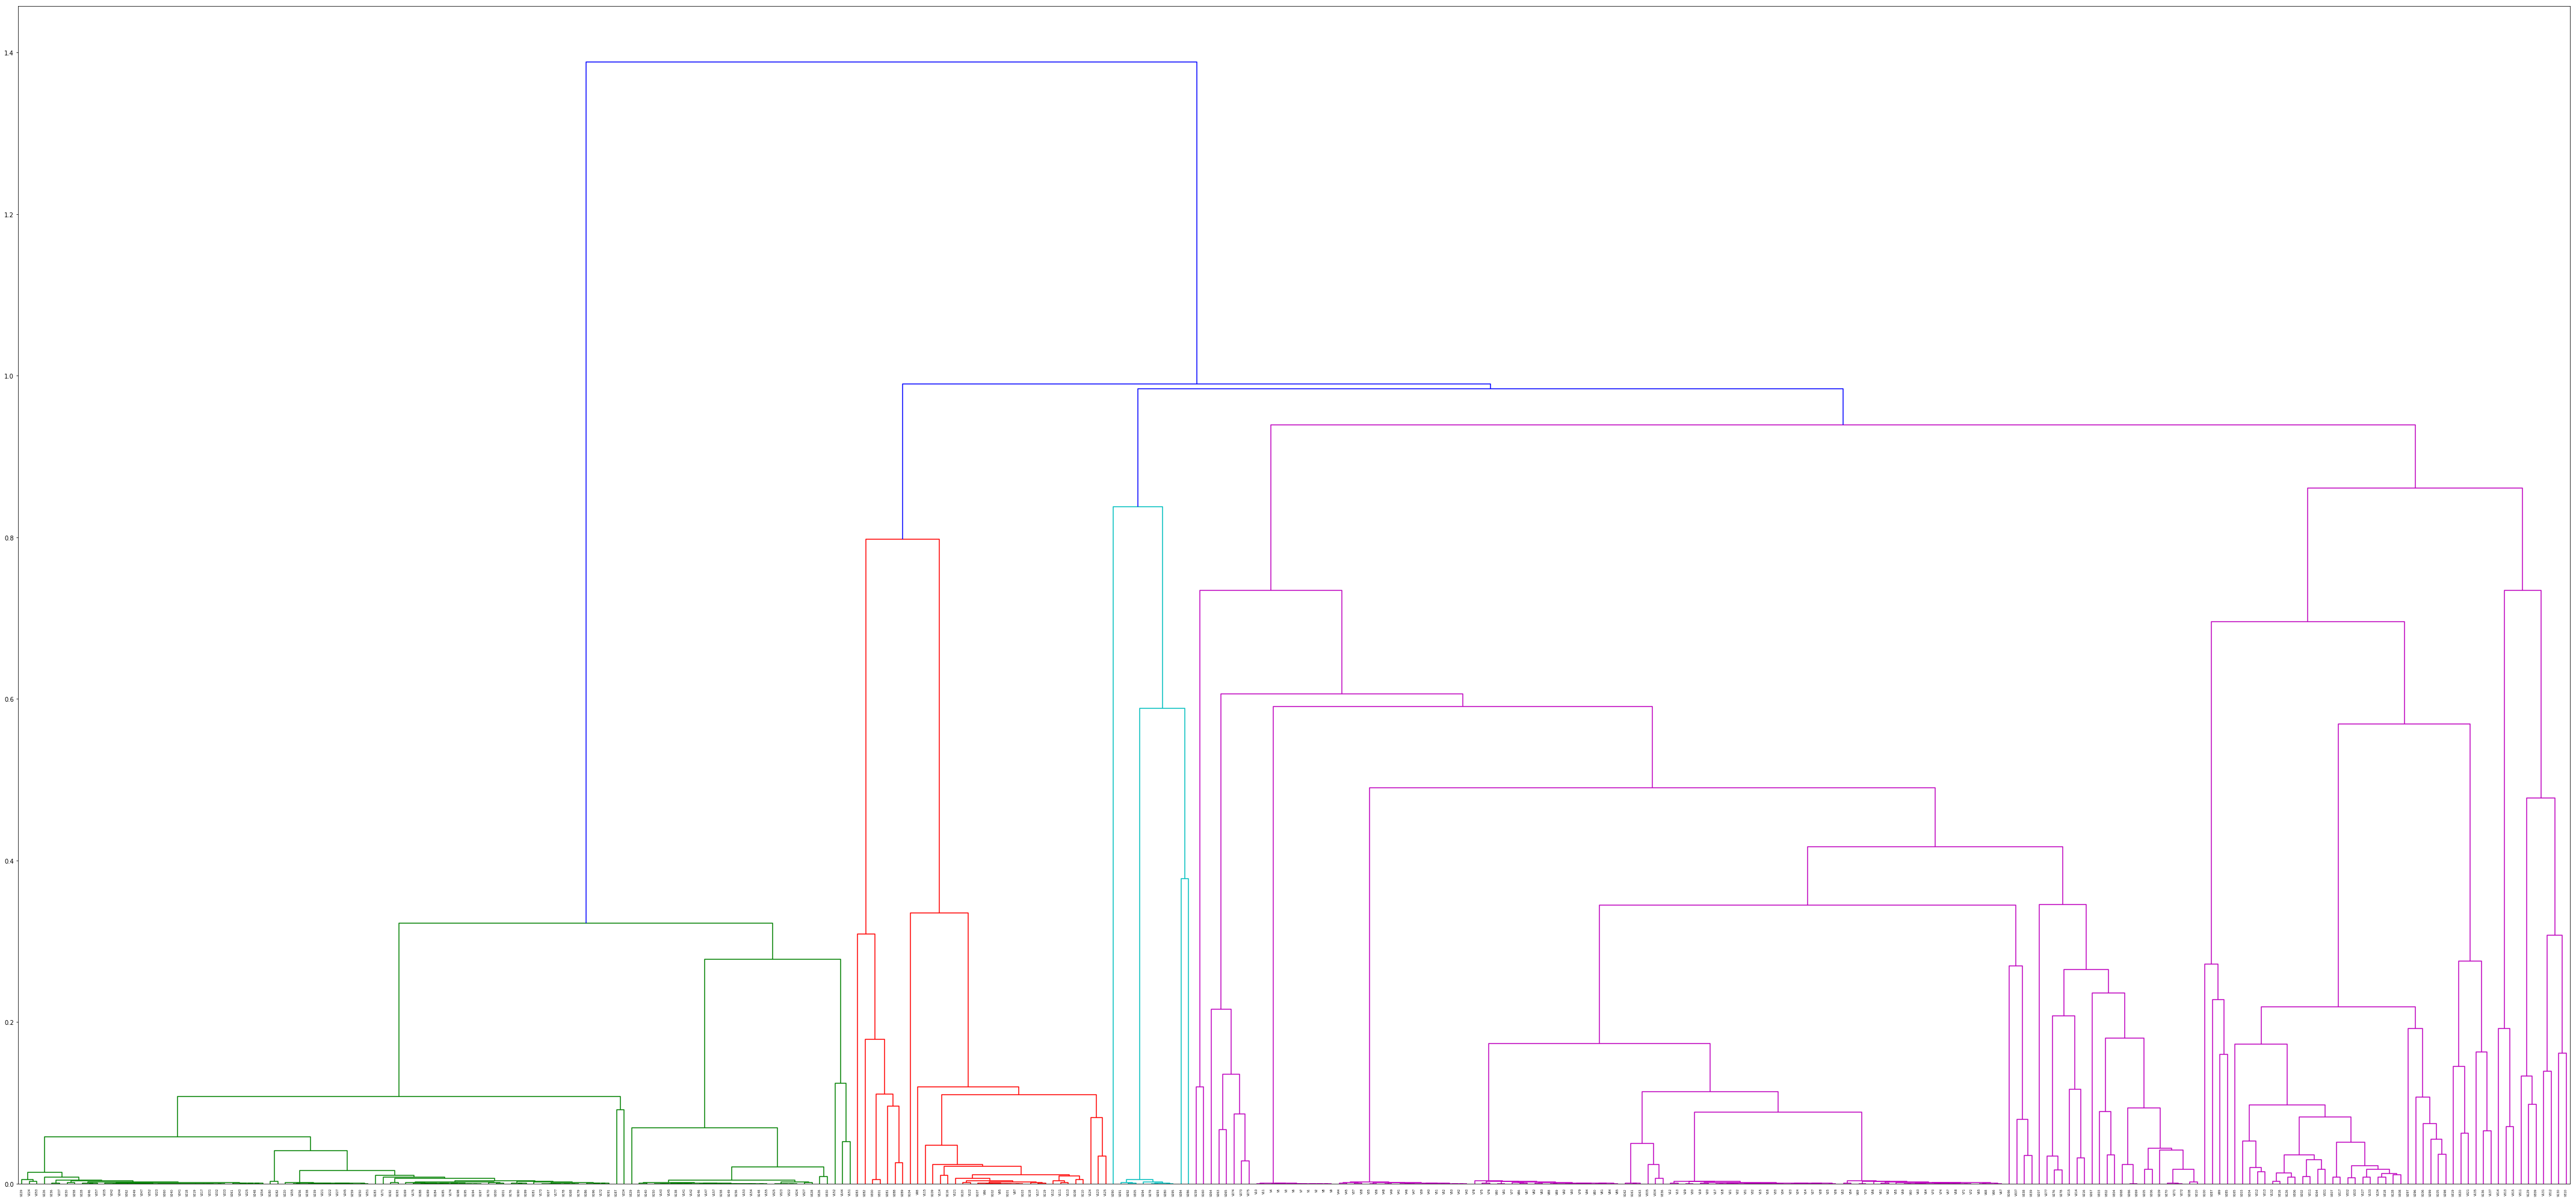

In [29]:
import matplotlib.pyplot as plt
from scipy.cluster import hierarchy as hc
dataframe = train[filter_col]
corr = 1 - dataframe.corr() 

corr_condensed = hc.distance.squareform(corr) # convert to condensed
z = hc.linkage(corr_condensed, method='average')
fig, axes = plt.subplots(1, 1, figsize=(76, 36))
dendrogram = hc.dendrogram(z, labels=corr.columns)
axes.margins(2, 2)   
plt.show()

In [30]:

del dendrogram,dataframe,corr,corr_condensed,z
gc.collect()

85597

**Observations:**

1)The dendogram can be zoomed.

2) If you zoom and observe there are many cluster's in the **V** varaible.

3) We can use this observation to create new feature while dealing with Feature Engineering
    

**Id's ** in numerical Feature

In [31]:
filter_col = [col for col in num_cols if col.startswith('id')]
filter_col.append('TransactionAmt')
filter_col.append('isFraud')

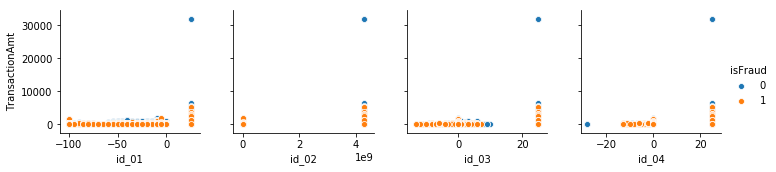

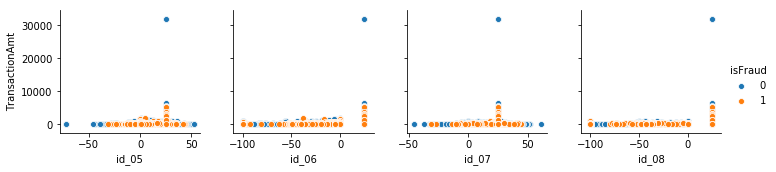

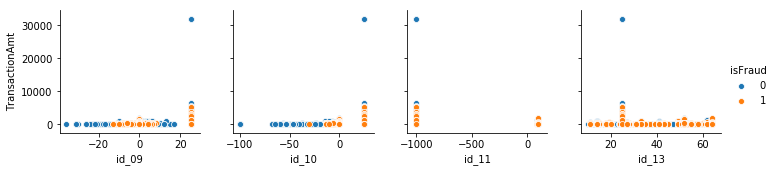

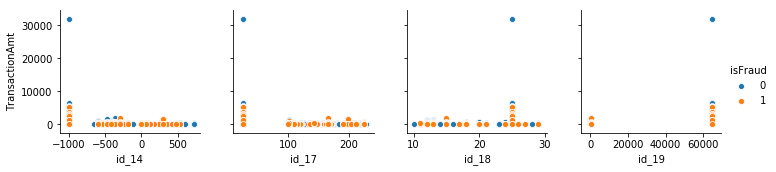

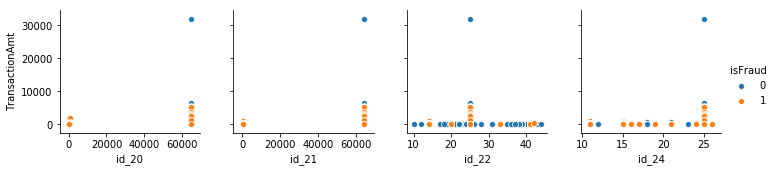

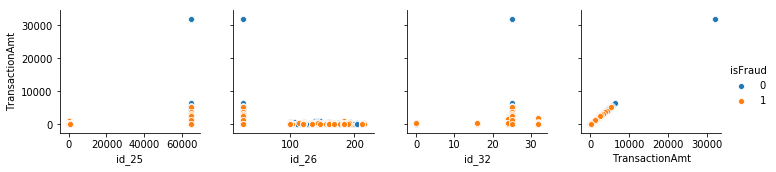

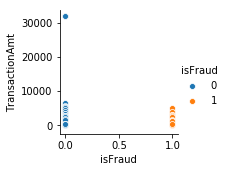

In [32]:
for i in range(0, len(filter_col), 4):
    sns.pairplot(data=train[filter_col],
                x_vars=filter_col[i:i+4],
                y_vars=['TransactionAmt'],
                hue='isFraud')

**Observations:**

1) From this pairplot we can clearly see that the transaction amount and Id's are for both Fraud and Non Fraud transaction's are mixed

**Card's in Numerical Data**

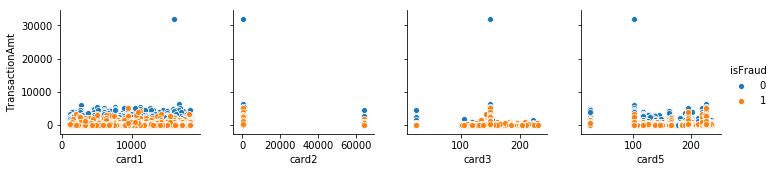

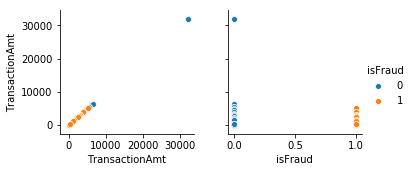

In [33]:
filter_col = [col for col in num_cols if col.startswith('card')]
filter_col.append('TransactionAmt')
filter_col.append('isFraud')
for i in range(0, len(filter_col), 4):
    sns.pairplot(data=train[filter_col],
                x_vars=filter_col[i:i+4],
                y_vars=['TransactionAmt'],
                hue='isFraud')

**Observation**

With Cards we can find that Fraud Transaction are made for the low amount's compared to the Non-Fraud Transaction's

**Address ** in Numerical data

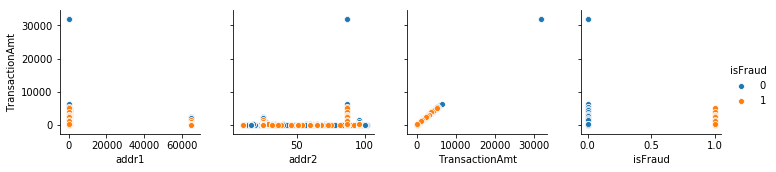

In [34]:
filter_col = [col for col in num_cols if col.startswith('addr')]
filter_col.append('TransactionAmt')
filter_col.append('isFraud')
for i in range(0, len(filter_col), 4):
    sns.pairplot(data=train[filter_col],
                x_vars=filter_col[i:i+4],
                y_vars=['TransactionAmt'],
                hue='isFraud')


## Feature Engineering

Feature Engineering part of this kernel is highly influenced by this Discussion :https://www.kaggle.com/c/ieee-fraud-detection/discussion/101203#latest-631034

**NAN Processing**

In [35]:
for col in cat_cols:
    train[col]=train[col].fillna('empty')
    test[col]=test[col].fillna('empty')

We have already processed the missing variables in numerical as -999 in numerical variables.

We have already processed the missing variables in categorical variable as empty 

This is because you give np.nan to LGBM, then at each tree node split, it will split the non-NAN values and then send all the NANs to either the left child or right child depending on what’s best. Therefore NANs get special treatment at every node and can become overfit.

**Creating new Features**

In [36]:
train['TransactionAmt_to_mean_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_mean_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('mean')
train['TransactionAmt_to_std_card1'] = train['TransactionAmt'] / train.groupby(['card1'])['TransactionAmt'].transform('std')
train['TransactionAmt_to_std_card4'] = train['TransactionAmt'] / train.groupby(['card4'])['TransactionAmt'].transform('std')

test['TransactionAmt_to_mean_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_mean_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('mean')
test['TransactionAmt_to_std_card1'] = test['TransactionAmt'] / test.groupby(['card1'])['TransactionAmt'].transform('std')
test['TransactionAmt_to_std_card4'] = test['TransactionAmt'] / test.groupby(['card4'])['TransactionAmt'].transform('std')

train['id_02_to_mean_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('mean')
train['id_02_to_mean_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('mean')
train['id_02_to_std_card1'] = train['id_02'] / train.groupby(['card1'])['id_02'].transform('std')
train['id_02_to_std_card4'] = train['id_02'] / train.groupby(['card4'])['id_02'].transform('std')

test['id_02_to_mean_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('mean')
test['id_02_to_mean_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('mean')
test['id_02_to_std_card1'] = test['id_02'] / test.groupby(['card1'])['id_02'].transform('std')
test['id_02_to_std_card4'] = test['id_02'] / test.groupby(['card4'])['id_02'].transform('std')

train['D15_to_mean_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('mean')
train['D15_to_mean_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('mean')
train['D15_to_std_card1'] = train['D15'] / train.groupby(['card1'])['D15'].transform('std')
train['D15_to_std_card4'] = train['D15'] / train.groupby(['card4'])['D15'].transform('std')

test['D15_to_mean_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('mean')
test['D15_to_mean_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('mean')
test['D15_to_std_card1'] = test['D15'] / test.groupby(['card1'])['D15'].transform('std')
test['D15_to_std_card4'] = test['D15'] / test.groupby(['card4'])['D15'].transform('std')

train['D15_to_mean_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('mean')
train['D15_to_mean_addr2'] = train['D15'] / train.groupby(['addr2'])['D15'].transform('mean')
train['D15_to_std_addr1'] = train['D15'] / train.groupby(['addr1'])['D15'].transform('std')
train['D15_to_std_addr2'] = train['D15'] / train.groupby(['addr2'])['D15'].transform('std')

test['D15_to_mean_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('mean')
test['D15_to_mean_addr2'] = test['D15'] / test.groupby(['addr2'])['D15'].transform('mean')
test['D15_to_std_addr1'] = test['D15'] / test.groupby(['addr1'])['D15'].transform('std')
test['D15_to_std_addr2'] = test['D15'] / test.groupby(['addr2'])['D15'].transform('std')



train[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = train['P_emaildomain'].str.split('.', expand=True)
train[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = train['R_emaildomain'].str.split('.', expand=True)
test[['P_emaildomain_1', 'P_emaildomain_2', 'P_emaildomain_3']] = test['P_emaildomain'].str.split('.', expand=True)
test[['R_emaildomain_1', 'R_emaildomain_2', 'R_emaildomain_3']] = test['R_emaildomain'].str.split('.', expand=True)

**Label  Encoding**

In [37]:
cols=train.columns
num_cols=train._get_numeric_data().columns
cat_cols=list(set(cols)-set(num_cols))
print("Numeric Columns:",num_cols)
print("Categoric Columns:",cat_cols)

Numeric Columns: Index(['TransactionID', 'isFraud', 'TransactionAmt', 'card1', 'card2', 'card3',
       'card5', 'addr1', 'addr2', 'dist1',
       ...
       'id_02_to_std_card1', 'id_02_to_std_card4', 'D15_to_mean_card1',
       'D15_to_mean_card4', 'D15_to_std_card1', 'D15_to_std_card4',
       'D15_to_mean_addr1', 'D15_to_mean_addr2', 'D15_to_std_addr1',
       'D15_to_std_addr2'],
      dtype='object', length=418)
Categoric Columns: ['ProductCD', 'P_emaildomain', 'M8', 'id_28', 'id_16', 'M1', 'R_emaildomain_1', 'R_emaildomain_3', 'M3', 'id_27', 'id_23', 'M2', 'card4', 'id_31', 'id_34', 'M9', 'id_38', 'M4', 'TransactionDT', 'P_emaildomain_1', 'M7', 'DeviceType', 'DeviceInfo', 'id_36', 'id_29', 'id_12', 'M5', 'R_emaildomain_2', 'id_35', 'R_emaildomain', 'P_emaildomain_3', 'id_37', 'id_30', 'id_33', 'card6', 'id_15', 'M6', 'P_emaildomain_2']


In [38]:
from sklearn.preprocessing import LabelEncoder
for i in cat_cols:
    train[i]=LabelEncoder().fit_transform(train[i].astype('str')) 
    test[i]=LabelEncoder().fit_transform(test[i].astype('str')) 
    
    #Reducing the memory
    if train[i].max()<128: 
        train[i] = train[i].astype('int8')
        test[i] = test[i].astype('int8')
        
    elif train[i].max()<32768: 
        test[i] = test[i].astype('int16')
        train[i] = train[i].astype('int16')
        
    else: 
        test[i]=test[i].astype('int32')
        train[i] = train[i].astype('int32')

**Noramlizing the columns**

In [39]:
cols=num_cols.drop('isFraud')
#cols=cols.drop('isFraud')

In [40]:
for col in cols:
    try:
        train[col] = ( train[col]-train[col].mean() ) / train[col].std() 
        test[col] = ( test[col]-test[col].mean() ) / test[col].std()
    except:
        print(col)

ofcourse, we can't do normalization with timedelta as we converted to date format that's why it is excepted


**Feature Selection**

These columns were selected based on the recursive feature elemination method.


In [41]:
useful_features = ['TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1',
                   'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13',
                   'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15', 'M2', 'M3',
                   'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V17',
                   'V19', 'V20', 'V29', 'V30', 'V33', 'V34', 'V35', 'V36', 'V37', 'V38', 'V40', 'V44', 'V45', 'V46', 'V47', 'V48',
                   'V49', 'V51', 'V52', 'V53', 'V54', 'V56', 'V58', 'V59', 'V60', 'V61', 'V62', 'V63', 'V64', 'V69', 'V70', 'V71',
                   'V72', 'V73', 'V74', 'V75', 'V76', 'V78', 'V80', 'V81', 'V82', 'V83', 'V84', 'V85', 'V87', 'V90', 'V91', 'V92',
                   'V93', 'V94', 'V95', 'V96', 'V97', 'V99', 'V100', 'V126', 'V127', 'V128', 'V130', 'V131', 'V138', 'V139', 'V140',
                   'V143', 'V145', 'V146', 'V147', 'V149', 'V150', 'V151', 'V152', 'V154', 'V156', 'V158', 'V159', 'V160', 'V161',
                   'V162', 'V163', 'V164', 'V165', 'V166', 'V167', 'V169', 'V170', 'V171', 'V172', 'V173', 'V175', 'V176', 'V177',
                   'V178', 'V180', 'V182', 'V184', 'V187', 'V188', 'V189', 'V195', 'V197', 'V200', 'V201', 'V202', 'V203', 'V204',
                   'V205', 'V206', 'V207', 'V208', 'V209', 'V210', 'V212', 'V213', 'V214', 'V215', 'V216', 'V217', 'V219', 'V220',
                   'V221', 'V222', 'V223', 'V224', 'V225', 'V226', 'V227', 'V228', 'V229', 'V231', 'V233', 'V234', 'V238', 'V239',
                   'V242', 'V243', 'V244', 'V245', 'V246', 'V247', 'V249', 'V251', 'V253', 'V256', 'V257', 'V258', 'V259', 'V261',
                   'V262', 'V263', 'V264', 'V265', 'V266', 'V267', 'V268', 'V270', 'V271', 'V272', 'V273', 'V274', 'V275', 'V276',
                   'V277', 'V278', 'V279', 'V280', 'V282', 'V283', 'V285', 'V287', 'V288', 'V289', 'V291', 'V292', 'V294', 'V303',
                   'V304', 'V306', 'V307', 'V308', 'V310', 'V312', 'V313', 'V314', 'V315', 'V317', 'V322', 'V323', 'V324', 'V326',
                   'V329', 'V331', 'V332', 'V333', 'V335', 'V336', 'V338', 'id_01', 'id_02', 'id_03', 'id_05', 'id_06', 'id_09',
                   'id_11', 'id_12', 'id_13', 'id_14', 'id_15', 'id_17', 'id_19', 'id_20', 'id_30', 'id_31', 'id_32', 'id_33',
                   'id_36', 'id_37', 'id_38', 'DeviceType', 'DeviceInfo']


cols_to_drop = [col for col in train.columns if col not in useful_features]
cols_to_drop.remove('isFraud')
cols_to_drop.remove('TransactionID')
cols_to_drop.remove('TransactionDT')

In [42]:
train=train.drop(cols_to_drop,axis=1)
test=test.drop(cols_to_drop,axis=1)

gc.collect()

12

## Modelling

In [43]:
Y=train['isFraud']
train=train.drop('isFraud',axis=1)
train=train.drop('TransactionID',axis=1)
gc.collect()

0

In [44]:
import lightgbm as lgb
model_lgb = lgb.LGBMClassifier(bagging_fraction=0.4181193142567742, bagging_seed=11,
                               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
                               feature_fraction=0.3797454081646243, importance_type='split',
                               learning_rate=0.006883242363721497, max_depth=-1, metric='auc',
                               min_child_samples=20, min_child_weight=0.03454472573214212,
                               min_data_in_leaf=106, min_split_gain=0.0, n_estimators=100,
                               n_jobs=-1, num_boost_round=5090, num_leaves=491,
                               objective='binary', random_state=47,
                               reg_alpha=0.3899927210061127, reg_lambda=0.6485237330340494,
                               silent=True, subsample=1.0, subsample_for_bin=200000,
                               subsample_freq=0, verbosity=-1)
model_lgb.fit(train,Y)

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


LGBMClassifier(bagging_fraction=0.4181193142567742, bagging_seed=11,
               boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
               feature_fraction=0.3797454081646243, importance_type='split',
               learning_rate=0.006883242363721497, max_depth=-1, metric='auc',
               min_child_samples=20, min_child_weight=0.03454472573214212,
               min_data_in_leaf=106, min_split_gain=0.0, n_estimators=100,
               n_jobs=-1, num_boost_round=5090, num_leaves=491,
               objective='binary', random_state=47,
               reg_alpha=0.3899927210061127, reg_lambda=0.6485237330340494,
               silent=True, subsample=1.0, subsample_for_bin=200000,
               subsample_freq=0, verbosity=-1)

In [45]:
submission=pd.DataFrame()
submission['TransactionID']=test['TransactionID']
test=test.drop('TransactionID',axis=1)
submission['isFraud'] = model_lgb.predict_proba(test)[:, 1]
submission['TransactionID']=pd.read_csv("/kaggle/input/ieee-fraud-detection/test_transaction.csv")['TransactionID']
submission.to_csv('Results.csv', index=False)

In [46]:
from IPython.display import FileLink
FileLink(r'Results.csv')

/kaggle/working/Results.csv

**I will be working extenssively on Feature Engineering and Modelling part**

**Stay tuned for more updates**

**If you find this kernel useful just leave a upvote**